## 1.Reading Data

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
data1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data1, data2])

## 2.Preprocessing Text

In [4]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [6]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(lines):
    head_lines = list()
    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        words=" ".join(words)
        head_lines.append(words)
    return head_lines

In [7]:
>>> import nltk
>>> nltk.download('punkt')


>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(lines):
    head_lines = list()
    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        words=" ".join(words)
        head_lines.append(words)
    return head_lines

In [9]:
import pandas as pd
from tqdm import tqdm
import re 
from sklearn.model_selection import train_test_split

In [11]:
X=data["headline"]
Y=data["is_sarcastic"]

In [12]:
X = CleanTokenize(X)

## 3.Train,Cv and Test

In [13]:
import pandas as pd
from tqdm import tqdm
import re 
from sklearn.model_selection import train_test_split

In [14]:
x_tr,x_test,y_tr,y_test=train_test_split(X,Y,test_size=0.30,random_state=42,stratify=Y)

x_train,x_cv,y_train,y_cv=train_test_split(x_tr,y_tr,test_size=0.30,random_state=42,stratify=y_tr)

In [16]:
print(len(x_train),len(x_cv),len(x_test))

27110 11619 16599


## 4.Deep learning Model
### 4.1 Tokenization

In [17]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
#tokenizer data
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

24440


In [20]:
max_len = 25

### 4.2. padding and text to sequence

In [21]:
train_sequences = tokenizer.texts_to_sequences(x_train)

train_padded = pad_sequences(
    train_sequences, maxlen=max_len, truncating="post", padding="post"
)

cv_sequences = tokenizer.texts_to_sequences(x_cv)
cv_padded = pad_sequences(
    cv_sequences, maxlen=max_len, padding="post", truncating="post"
)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, padding="post", truncating="post"
)

### 4.3. Download word2vec-google-news-300 dimension vector

In [22]:
import gensim.downloader
import gensim

In [23]:
words = []
for i in x_train:
    words.append(i.split())
words[:5]

[['snowstorm', 'chicago', 'delays', 'hundreds', 'morning', 'murders'],
 ['colleges', 'biggest', 'sweet', 'tooth', 'ranking', 'grubhub'],
 ['greek',
  'populace',
  'woken',
  'angela',
  'merkels',
  'voice',
  'booming',
  'loudspeakers',
  'across',
  'country'],
 ['techie', 'things', 'everyone', 'needs', 'know'],
 ['royal', 'baby', 'born']]

In [24]:
model=gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### 4.4. Word Embedding

In [25]:
vocab_size=len(tokenizer.word_index)+1
embedding_dim=300

In [26]:
skipped_words=0
embedding_dim=300
embedding_matrix=np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
    embedding_vector = model[word]
  except:
    skipped_words=skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index]=embedding_vector
print("Embedding  matrix shape:",embedding_matrix.shape)

Embedding  matrix shape: (24440, 300)


In [28]:
embedding_layer=Embedding(vocab_size, output_dim=embedding_dim, 
                          weights=[embedding_matrix], 
                          input_length=25, trainable=False)

### 4.5. Training deep learning model

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM,GlobalMaxPool1D,Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [30]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           7332000   
                                                                 
 lstm (LSTM)                 (None, 25, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 25, 128)           98816     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                          

In [35]:
history = model.fit(train_padded,y_train, batch_size=32, epochs=15, validation_data=(cv_padded, y_cv), verbose=1)

Epoch 1/15
848/848 [==============================] - 113s 133ms/step - loss: 0.3652 - acc: 0.8371 - val_loss: 0.3812 - val_acc: 0.8260
Epoch 2/15
848/848 [==============================] - 113s 134ms/step - loss: 0.3304 - acc: 0.8561 - val_loss: 0.4034 - val_acc: 0.8169
Epoch 3/15
848/848 [==============================] - 112s 132ms/step - loss: 0.2953 - acc: 0.8729 - val_loss: 0.3600 - val_acc: 0.8423
Epoch 4/15
848/848 [==============================] - 109s 129ms/step - loss: 0.2678 - acc: 0.8862 - val_loss: 0.3324 - val_acc: 0.8589
Epoch 5/15
848/848 [==============================] - 112s 132ms/step - loss: 0.2432 - acc: 0.8994 - val_loss: 0.3334 - val_acc: 0.8611
Epoch 6/15
848/848 [==============================] - 111s 131ms/step - loss: 0.2239 - acc: 0.9068 - val_loss: 0.3153 - val_acc: 0.8700
Epoch 7/15
848/848 [==============================] - 112s 132ms/step - loss: 0.2008 - acc: 0.9214 - val_loss: 0.3403 - val_acc: 0.8657
Epoch 8/15
848/848 [============================

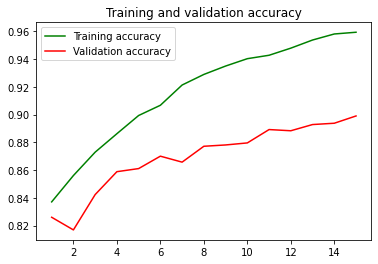

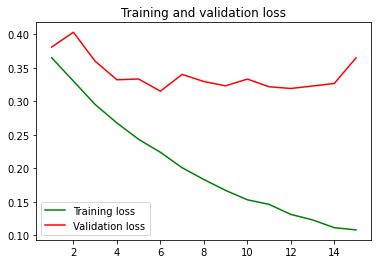

In [37]:
# Plot results
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 4.6. Testing

Accuracy on test set: 89.415%
F1-Score on test set: 0.879
-------------------- confusion matrix --------------------


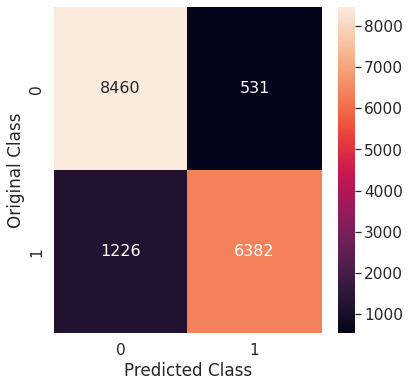

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = model.predict(test_padded)
y_pred = np.round(y_pred).astype(int)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(6,6))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()